### Importing Libraries and Defining Paths

In [1]:
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
filterwarnings('ignore')

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import fiona 
from shapely.geometry import shape, box
import rasterio
from PIL import Image, ImageDraw
Image.MAX_IMAGE_PIXELS = None
import tensorflow as tf
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline 
from patchify import patchify, unpatchify
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd
import copy

2023-09-10 18:28:45.538482: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
sys.path.append(os.path.join(ROOT_DIR, "mrcnn"))

In [4]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [5]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

DATASET_DIR = os.path.join(ROOT_DIR, "Dataset")

# Local path to trained weights file
COCO_MODEL_PATH = "../models/mask_rcnn_coco.h5"
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [6]:
# Check if GPU is available
tf.config.list_physical_devices('GPU')

2023-09-10 18:28:47.948725: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-09-10 18:28:47.986190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:51:00.0 name: NVIDIA A30 computeCapability: 8.0
coreClock: 1.44GHz coreCount: 56 deviceMemorySize: 23.50GiB deviceMemoryBandwidth: 869.04GiB/s
2023-09-10 18:28:47.986289: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-09-10 18:28:48.025743: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-09-10 18:28:48.025905: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-09-10 18:28:48.030407: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2023

[]

### Dataset Preparation and Loading

In [7]:
class BuildingDataset(utils.Dataset):
     
    def load_dataset(self, dataset_dir, start=1, end=400):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("BuildingDataset", 1, "building")

        # define data locations for images and annotations
        images_dir = os.path.join(dataset_dir, "cropped_png_files/")
        annotations_dir = os.path.join(dataset_dir, "annotations/")


        for place_dir in os.listdir(images_dir)[start:end]:
            place_path = os.path.join(images_dir, place_dir)
            if os.path.isdir(place_path):
                annotation_file = f"{place_dir}_Builtup_Area.shp"
                annotation_path = os.path.join(annotations_dir, annotation_file)

                for image_dir in os.listdir(place_path):
                    if image_dir.lower().endswith('.png'):
                        image_dir_path = os.path.join(place_path, image_dir)
                        tif_dir_path = image_dir_path.replace("cropped_png_files", "cropped_tif_files")[:-4] + ".tif"
                        self.add_image('BuildingDataset', image_id=image_dir, path=image_dir_path, annotation=annotation_path, tif_path = tif_dir_path)

    def get_tif_bounding_box(self, tif_dataset):
        bounds = tif_dataset.bounds
        min_x, min_y, max_x, max_y = bounds.left, bounds.bottom, bounds.right, bounds.top
        return (min_x, min_y, max_x, max_y)

    def get_polygons(self, shp_path):
        # Open the shapefile and read the polygons:
        polygons = []
        with fiona.open(shp_path, "r") as shapefile:
            for feature in shapefile:
                geometry = shape(feature["geometry"])
                if(geometry.geom_type=="MultiPolygon"):
                    continue
                polygons.append((geometry, feature["properties"]))
        return polygons

    def get_filtered_polygons(self, polygons, tif_dataset):
        # Get the bounding box of the TIF file
        tif_bbox = self.get_tif_bounding_box(tif_dataset)
        
        # Filter the polygons based on the intersection with the TIF file's bounding box:
        filtered_polygons = []
        for polygon, properties in polygons:
            polygon_bbox = polygon.bounds
            if box(*tif_bbox).intersects(box(*polygon_bbox)):
                filtered_polygons.append(polygon)

        return filtered_polygons
    
    def fill_between(self, polygon, height, width):
        """
        Returns: a bool array
        """
        img = Image.new('1', (width, height), False)
        ImageDraw.Draw(img).polygon(polygon, outline=True, fill=True)
        mask = np.array(img)

        return mask
    
    def load_mask(self, image_id):
        tif_file_path = self.image_info[image_id]['tif_path']
        shp_file_path = self.image_info[image_id]['annotation']
        
        tif_dataset = rasterio.open(tif_file_path)
        height = tif_dataset.height
        width = tif_dataset.width
        transform = tif_dataset.transform

        polygons = self.get_polygons(shp_file_path)
        filtered_polygons = self.get_filtered_polygons(polygons, tif_dataset)
        
        masks = np.zeros((height, width, len(filtered_polygons)), dtype=np.uint8)

        for idx, polygon in enumerate(filtered_polygons):
            coordinates = list()
            for point in polygon.exterior.coords:
                x, y = point
                pixel_x, pixel_y = ~transform * (x, y)
                pixel_x = width - 1 if pixel_x > width else pixel_x
                pixel_y = height - 1 if pixel_y > height else pixel_y
                coordinates.append((pixel_x, pixel_y))
            
            mask = self.fill_between(coordinates, height, width)
            masks[:, :, idx] = mask
        
        class_ids = np.asarray([1]*masks.shape[2])

        return masks.astype(np.bool), class_ids.astype(np.int32)

In [8]:
# Training dataset
dataset_train = BuildingDataset()
dataset_train.load_dataset(DATASET_DIR, 0, 58)
dataset_train.prepare()

In [9]:
len(dataset_train.image_ids)

11208

In [10]:
# Validation dataset
dataset_val = BuildingDataset()
dataset_val.load_dataset(DATASET_DIR, 58, 65)
dataset_val.prepare()

In [11]:
# Validation dataset
dataset_test = BuildingDataset()
dataset_test.load_dataset(DATASET_DIR, 65, 72)
dataset_test.prepare()

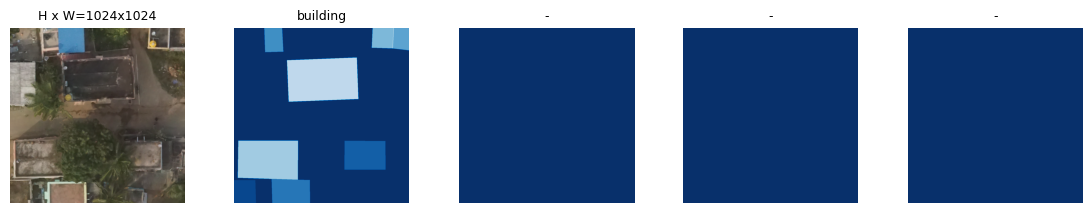

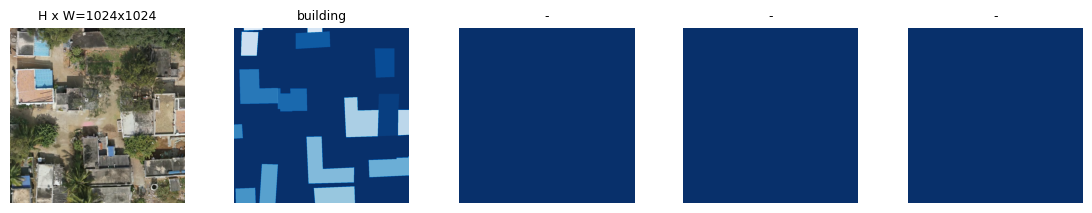

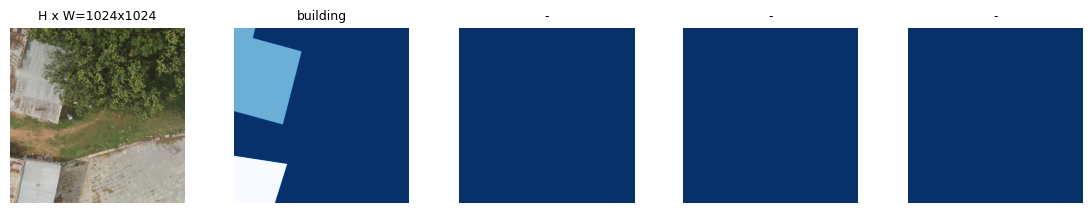

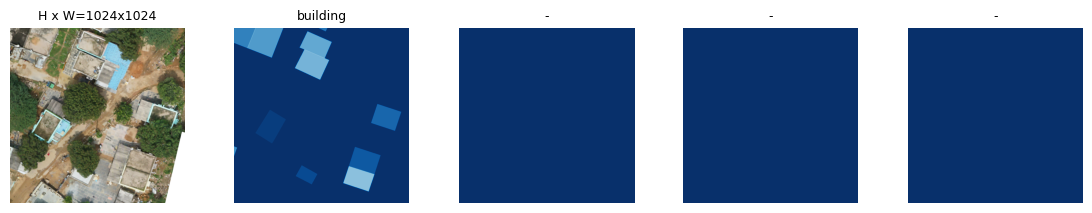

In [12]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids,4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

### Configurations

In [13]:
class TrainingConfig(Config):
    NAME = "BuildingDetection"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    STEPS_PER_EPOCH = 2770
    VALIDATION_STEPS = 234
    BACKBONE = "resnet101"
    NUM_CLASSES = 2 #bulding and background
    IMAGE_MAX_DIM = 1024
    IMAGE_MIN_DIM = 1024

    TRAIN_ROIS_PER_IMAGE = 50
    
    MAX_GT_INSTANCES = 50
    LOSS_WEIGHTS = {
        "rpn_class_loss": 2.,
        "rpn_bbox_loss": 1.,
        "mrcnn_class_loss": 1.,
        "mrcnn_bbox_loss": 1.,
        "mrcnn_mask_loss": 10.
    }

In [14]:
train_config = TrainingConfig()
# train_config.display()

In [15]:
class InferenceConfig(TrainingConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.9

inference_config = InferenceConfig()

In [16]:
model_train = modellib.MaskRCNN(mode="training", config=train_config, model_dir=MODEL_DIR)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [17]:
model_inference = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

Instructions for updating:
Use fn_output_signature instead


### Inference

In [18]:
# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "buildingdetection20230801T1248/mask_rcnn_buildingdetection_0043.h5")
# model_path = model_inference.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model_inference.load_weights(model_path, by_name=True)

Loading weights from  /home/cctv/Internship/Building_detection/logs/buildingdetection20230801T1248/mask_rcnn_buildingdetection_0043.h5


2023-09-10 18:29:02.736676: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 18:29:02.739638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-09-10 18:29:02.739657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      
2023-09-10 18:29:03.565056: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz


Re-starting from epoch 43


#### Visualize Results

323
original_image           shape: (1024, 1024, 3)       min:    1.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  int64
gt_class_id              shape: (7,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (7, 4)                min:    0.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  bool


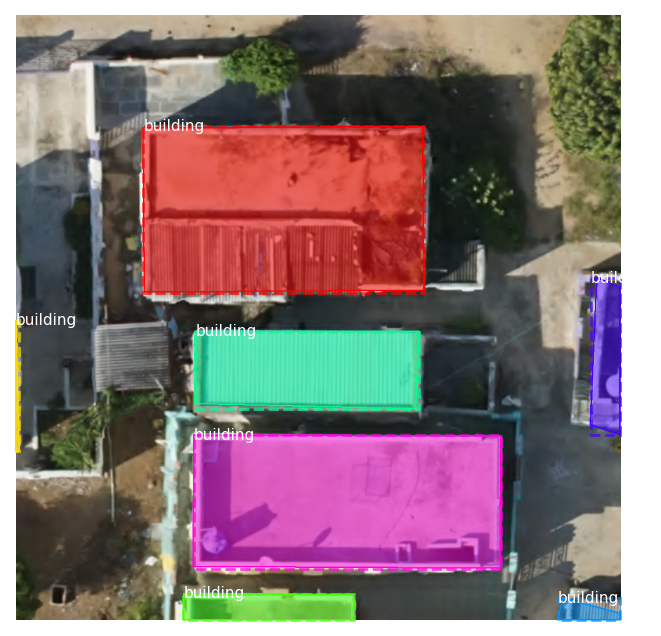

In [23]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
# image_id = 890
print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -122.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


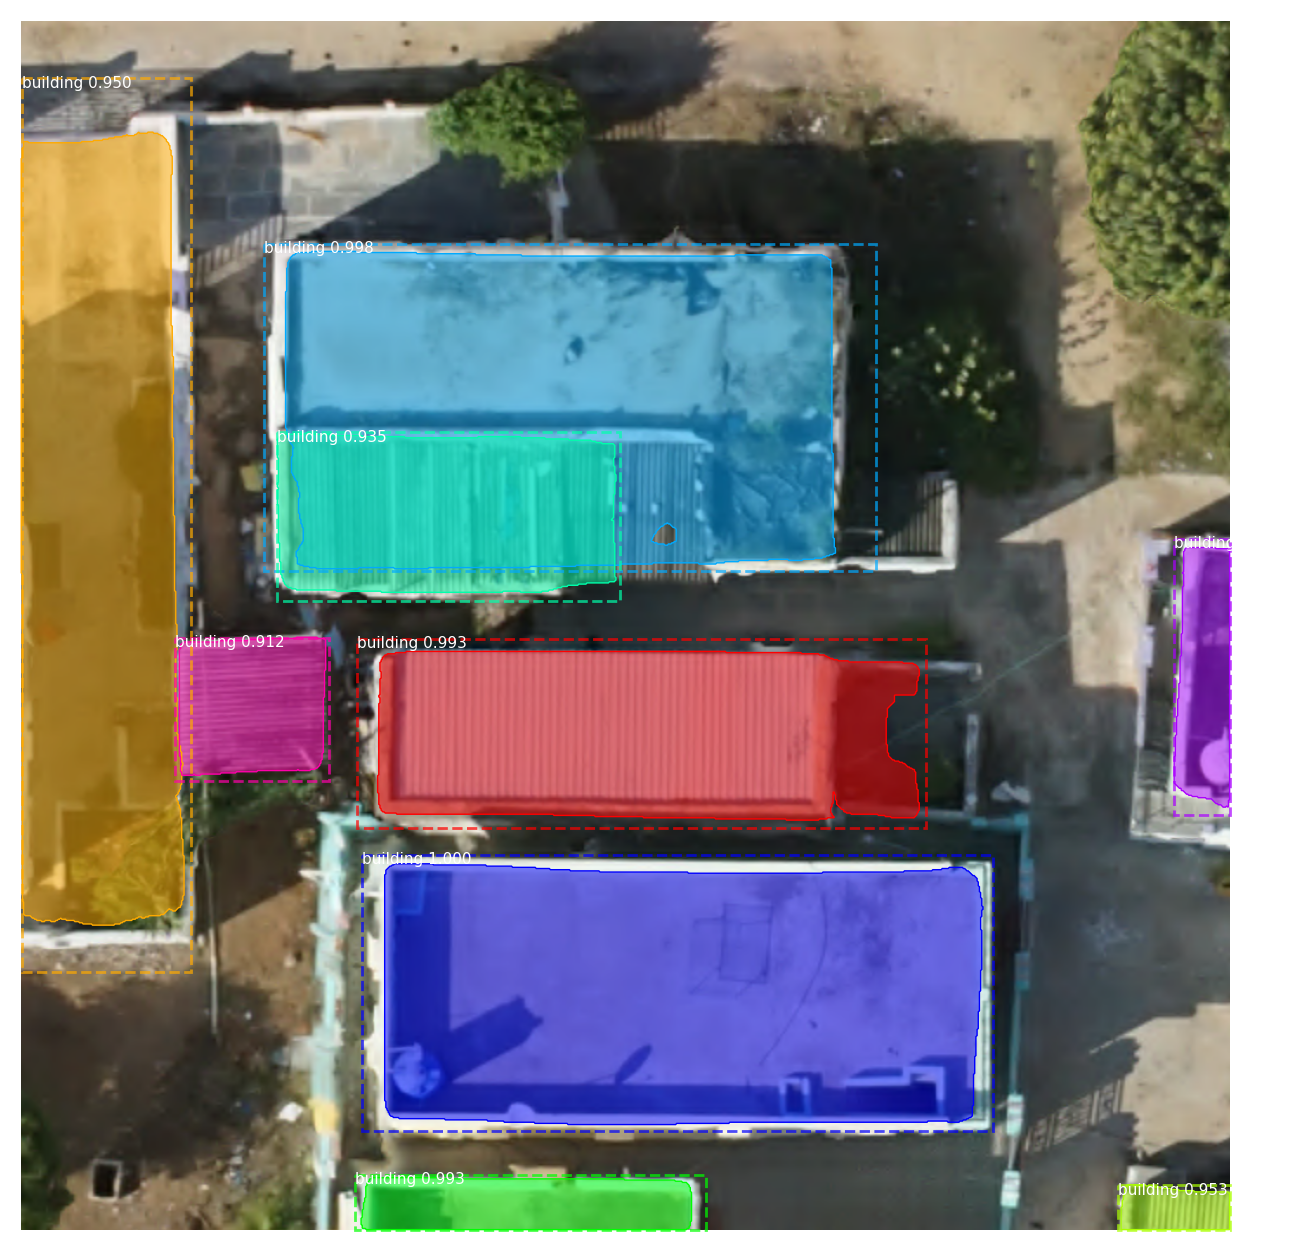

In [24]:
results = model_inference.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

#### Calculate accuracy

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
image_ids = dataset_test.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model_inference.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    # print(image_id, AP)
    if(np.isnan(AP)):
        continue
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

#### Run inference on multiple images and save results

In [ ]:
def save_results(image, masks, boxes, save_dir, scores, show_score = True, show_mask = True, show_polygon = True, eps = 0.001):
    N = boxes.shape[0]
    colors = visualize.random_colors(N)
    image_copy = image.copy()
    for i in range(N):
        color = colors[i]
        mask = masks[:, :, i]

        if(show_mask):
            image_copy = visualize.apply_mask(image_copy, mask, color)
        contours, _ = cv2.findContours(mask.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            epsilon = eps * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, closed=False)
            cv2.polylines(image_copy, [approx], isClosed=True, color=(0, 0, 0), thickness=2)
    cv2.imwrite(save_dir, image_copy[:, :, ::-1])

In [ ]:
def run_and_save(dataset, save_dir="../results2/"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for image_id in dataset.image_ids:
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config, 
                            image_id)
        results = model_inference.detect([original_image], verbose=1)
        r = results[0]
        masks = r['masks']
        boxes = r['rois']
        scores = r['scores']
        save_image_dir = os.path.join(save_dir, dataset.image_info[image_id]['id'])
        save_results(original_image, masks, boxes, save_image_dir, scores, show_mask = False, eps = 0.02)

In [ ]:
dataset_test = BuildingDataset()
dataset_test.load_dataset(DATASET_DIR, 59,60)
dataset_test.prepare()

In [ ]:
len(dataset_test.image_ids)

In [ ]:
run_and_save(dataset_test)

#### Run inference on single large image

In [ ]:
def extract_patches(image_path, patch_size, step):
    """
    Extract patches from an image and return the patches along with a padded image.

    Args:
        image_path (str): Path to the input image.
        patch_size (tuple): Size of each patch in (height, width) format.
        step (int): Step size for patch extraction.

    Returns:
        patches (numpy.ndarray): Extracted patches.
        padded_image (numpy.ndarray): Padded image to fit patches evenly.
    """
    # Open the image
    image = Image.open(image_path)
    
    # Convert the PIL image to a NumPy array
    image_np = np.array(image)
    
    # Calculate the number of patches in each dimension
    num_patches_y = (image_np.shape[0] + patch_size[0] - 1) // patch_size[0]
    num_patches_x = (image_np.shape[1] + patch_size[1] - 1) // patch_size[1]
    
    # Calculate the required padding to fit the patches evenly
    pad_y = num_patches_y * patch_size[0] - image_np.shape[0]
    pad_x = num_patches_x * patch_size[1] - image_np.shape[1]
    
    # Pad the image
    padded_image = np.pad(image_np, ((0, pad_y), (0, pad_x), (0, 0)), mode='constant')
    
    # Divide the padded image into patches
    patches = patchify(padded_image, patch_size, step=step)
    
    return patches, padded_image

In [ ]:
def save_patches(patches, save_dir):
    """
    Save patches as images to the specified directory.

    Args:
        patches (numpy.ndarray): 6D array of patches.
        save_dir (str): Directory path to save the patches.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i, j, 0, :, :, :]
            patch_image = Image.fromarray(patch)
            patch_image.save(os.path.join(save_dir, f'patch_{i}_{j}.png'))

    print("Patches saved successfully.")

In [ ]:
def is_mask_on_edge(mask, edge_percentage, mask_percentage):
    """
    Check if a mask is present on the edges of an image.

    Args:
        mask (numpy.ndarray): Binary mask.
        edge_percentage (float): Percentage of edges to consider (0 to 1).
        mask_percentage (float): Minimum percentage of mask pixels on an edge (0 to 1).

    Returns:
        bool: True if mask is on any edge, False otherwise.
    """
    height, width = mask.shape
    total_mask_area = np.sum(mask)
    edge_pixels = int(min(height, width) * edge_percentage)

    # Check top edge
    if np.sum(mask[:edge_pixels, :]) >= mask_percentage * total_mask_area:
        return True
    
    # Check bottom edge
    if np.sum(mask[-edge_pixels:, :]) >= mask_percentage * total_mask_area:
        return True
    
    # Check left edge
    if np.sum(mask[:, :edge_pixels]) >= mask_percentage * total_mask_area:
        return True
    
    # Check right edge
    if np.sum(mask[:, -edge_pixels:]) >= mask_percentage * total_mask_area:
        return True
    
    return False

In [ ]:
def find_polygons(r, x, y):
    """
    Find polygons from instance segmentation results.

    Args:
        r (dict): Result dictionary containing masks and bounding boxes.
        x (int): X-coordinate shift.
        y (int): Y-coordinate shift.

    Returns:
        polygons (list): List of Shapely Polygon objects representing objects.
    """
    masks = r['masks']
    bboxes = r['rois']
    n = bboxes.shape[0]
    polygons = []
    
    for i in range(n):
        mask = masks[:, :, i]
        mask = mask.astype(np.uint8)

        # Ignore incomplete building masks on sides of images
        if is_mask_on_edge(mask, 0.2, 0.5):
            continue
        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, closed=False)
            
            shifted_polygon = np.array(approx) + np.array([x, y])
            
            # Convert the shifted_polygon to a GeoDataFrame Polygon
            poly_coords = [(point[0][0], point[0][1]) for point in shifted_polygon]
            if len(poly_coords) >= 4:
                polygon = Polygon(poly_coords)
                polygons.append(polygon)
            
    return polygons

In [ ]:
def draw_polygons_on_image(image, output_dir, file_name, polygons, x, y, masks=None, show_mask=False):
    """
    Draw polygons on an image and save the result.

    Args:
        image (numpy.ndarray): Input image as NumPy array.
        output_dir (str): Directory to save the output image.
        file_name (str): Name of the output image file.
        polygons (list): List of Shapely Polygon objects representing objects.
        masks (numpy.ndarray): Binary masks (optional, for masking regions).
        show_mask (bool): Whether to apply masks to the image before drawing.
        x,y: pixel size by which polygons have to shifted

    Returns:
        None
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image = Image.fromarray(image)
    image_width, image_height = image.size
    
    if show_mask and masks is not None:
        N = masks.shape[2]
        colors = visualize.random_colors(N)
        for i in range(N):
            mask = masks[:, :, i]
            if is_mask_on_edge(mask, 0.2, 0.7):
                image = visualize.apply_mask(np.array(image), mask, colors[i])
                image = Image.fromarray(image)
    
    draw = ImageDraw.Draw(image)
    for polygon in polygons:
        if isinstance(polygon, MultiPolygon):
            for sub_polygon in polygon.geoms:
                coords = list(sub_polygon.exterior.coords)
                coords = [(coord[0] - x, coord[1] - y) for coord in coords]
                draw.polygon(coords, outline=(255, 0, 0), width=6) 
        else:
            coords = list(polygon.exterior.coords)
            coords = [(coord[0] - x, coord[1] - y) for coord in coords]
            draw.polygon(coords, outline=(255, 0, 0), width=6)
            
    image.save(os.path.join(output_dir, file_name))

In [ ]:
def apply_patch_overlap_adjustment(polygons, prev_polygons, overlap_threshold):
    adjusted_polygons = []
    for polygon in polygons:
        if not any(polygon.intersection(prev_poly).area >= overlap_threshold * polygon.area for prev_poly in prev_polygons):
            adjusted_polygons.append(polygon)
    return adjusted_polygons

In [ ]:
def process_patches_with_overlap_adjustment(image_path, patches, model_inference, step, overlap_threshold, output_shp_path):
    image = Image.open(image_path)
    image_width, image_height = image.size
    draw = ImageDraw.Draw(image)

    # Extract CRS from the TIFF image
    with rasterio.open(image_path) as src:
        transform = src.transform
        crs = src.crs
    
    patch_polygons = [[[] for _ in range(patches.shape[1])] for _ in range(patches.shape[0])]
    
    # Create a list to store all polygons for the shapefile
    all_polygons = []

    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i, j, 0, :, :, :3]
            r = model_inference.detect([patch])[0]
            polygons = find_polygons(r, j * step, i * step)
            
            if i > 0:
                prev_row_polygons = patch_polygons[i - 1][j]
                polygons = apply_patch_overlap_adjustment(polygons, prev_row_polygons, overlap_threshold)
            
            if j > 0:
                prev_col_polygons = patch_polygons[i][j - 1]
                polygons = apply_patch_overlap_adjustment(polygons, prev_col_polygons, overlap_threshold)
            
            if j > 0:
                prev_row_polygons = patch_polygons[i - 1][j - 1]
                polygons = apply_patch_overlap_adjustment(polygons, prev_row_polygons, overlap_threshold)
            
            if j < patches.shape[1]-1:
                prev_row_polygons = patch_polygons[i - 1][j + 1]
                polygons = apply_patch_overlap_adjustment(polygons, prev_row_polygons, overlap_threshold)
            
            patch_polygons[i][j] = polygons

            # Append the adjusted polygons to the all_polygons list
            all_polygons.extend(polygons)
            
            # for polygon in polygons:
            #     if isinstance(polygon, MultiPolygon):
            #         for sub_polygon in polygon.geoms:
            #             coords = list(sub_polygon.exterior.coords)
            #             draw.polygon(coords, outline=(255, 0, 0), width=6) 
            #     else:
            #         coords = list(polygon.exterior.coords)
            #         draw.polygon(coords, outline=(255, 0, 0), width=6)
            # print(len(polygons))
            # draw_polygons_on_image(patch, "../Dataset/output", "patch_"+str(i)+"_"+str(j)+".png", polygons, j*step, i*step)
            print(f"Patch {i},{j} completed")

    transformed_polygons = []
    for polygon in all_polygons:
        points = []
        for point in polygon.exterior.coords:
            x, y = point
            lon, lat = transform * (x + 0.5, y + 0.5)
            points.append((lon, lat))
        transformed_polygons.append(Polygon(points))


    # Create a GeoDataFrame from the list of polygons
    geometry = gpd.GeoSeries(transformed_polygons)
    print(len(all_polygons))
    gdf = gpd.GeoDataFrame(geometry=geometry, crs=crs)  # You might need to adjust the CRS
    
    # Save the GeoDataFrame as a shapefile
    gdf.to_file(output_shp_path)
    
    # return image

In [ ]:
overlap_threshold = 0.5  # Adjust this threshold as needed
image_path = "../Dataset/test_files/Chowtakuntapalli_ORTHO_H1.tif"  # Path to your test image
patch_size = (1024, 1024, 3)  # Adjust this to the desired patch size and channel count
step = 512

In [ ]:
patches, padded_image = extract_patches(image_path, patch_size, step)
print(f"Number of patches: {patches.shape[0] * patches.shape[1]}")
print(f"Shape of a single patch: {patches[0, 0, 0].shape}")

In [ ]:
save_patches(patches, "../Dataset/patches")

In [ ]:
output_shp_path = "../shp_files/output_shp.shp"
process_patches_with_overlap_adjustment(image_path, patches, model_inference, step, overlap_threshold, output_shp_path)

In [ ]:
# output_image = process_patches_with_overlap_adjustment(image_path, patches, model_inference, step, overlap_threshold)
# output_image.save("output.png")

In [ ]:
input_folder = "../Dataset/test_files3/"
output_folder = "../results"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for tif_folder in os.listdir(input_folder):
    geotiff_folder = os.path.join(input_folder, tif_folder)
    geotiff_folder = os.path.join(geotiff_folder, "GeoTiff")
    curr_output_folder = os.path.join(output_folder, tif_folder)
    if not os.path.exists(curr_output_folder):
        os.makedirs(curr_output_folder)

    for filename in os.listdir(geotiff_folder):    
        if filename.endswith(".tif"):
            input_path = os.path.join(geotiff_folder, filename)
            print("working on", filename)

            inside_folder = os.path.join(curr_output_folder, f"{filename[:-4]}")
            if not os.path.exists(inside_folder):
                os.makedirs(inside_folder)
                
            output_path = os.path.join(inside_folder, f"output_{filename[:-4]}"+".shp")
            print(output_path)
            if os.path.exists(output_path):
                continue
            patches, padded_image = extract_patches(input_path, patch_size, step)
            # output_image = process_patches_with_overlap_adjustment(input_path, patches, model_inference, step, overlap_threshold)
            
            # output_image.save(output_path)
            process_patches_with_overlap_adjustment(input_path, patches, model_inference, step, overlap_threshold, output_path)

working on Gopepalli_geotiff_H1.tif
../results/Puttaparthi_Nallamada_Gopepalli_02627900/Gopepalli_geotiff_H1/output_Gopepalli_geotiff_H1.shp
working on Gopepalli_geotiff_H2.tif
../results/Puttaparthi_Nallamada_Gopepalli_02627900/Gopepalli_geotiff_H2/output_Gopepalli_geotiff_H2.shp
Patch 0,0 completed
Patch 0,1 completed
Patch 0,2 completed
Patch 0,3 completed
Patch 0,4 completed
Patch 0,5 completed
Patch 0,6 completed
Patch 0,7 completed
Patch 0,8 completed
Patch 0,9 completed
Patch 0,10 completed
Patch 0,11 completed
Patch 0,12 completed
Patch 0,13 completed
Patch 0,14 completed
Patch 0,15 completed
Patch 0,16 completed
Patch 0,17 completed
Patch 0,18 completed
Patch 0,19 completed
Patch 0,20 completed
Patch 0,21 completed
Patch 0,22 completed
Patch 0,23 completed
Patch 0,24 completed
Patch 0,25 completed
Patch 0,26 completed
Patch 0,27 completed
Patch 0,28 completed
Patch 0,29 completed
Patch 0,30 completed
Patch 1,0 completed
Patch 1,1 completed
Patch 1,2 completed
Patch 1,3 complet